# Week 1 Submission for NBA career modelling

## Load Required Packages 

In [1]:
import os
import pandas as pd #data manipulation
import numpy as np
import sklearn # models
import seaborn as sns # visualisation
import matplotlib.pyplot as plt # visualisation
import xgboost as xgb
from xgboost import plot_importance
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
%matplotlib inline 
# visualisation inline in notebook

/Users/james/projects/adsi/adsi/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Import Data 

In [2]:
## Import Data 
data_path = '/Users/james/projects/adsi/group1_nba_career_prediction/data/raw'
train_data = data_path + '/train.csv'
test_data = data_path + '/test.csv'
df_train = pd.read_csv(train_data)
df_test = pd.read_csv(test_data)
df_test

,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,1,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,7.3,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,8194,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,35.1,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,-0.0,1.8
2,3,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,44.8,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,8196,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,13.5,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,8197,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,38.7,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3794,8175,84,21.2,8.7,3.4,6.7,50.2,0.0,-0.0,-4.5,1.7,2.5,68.1,1.9,2.3,3.9,1.5,0.6,0.3,2.0
3795,8176,49,16.3,6.4,2.9,6.6,44.4,-0.1,-0.4,19.8,1.0,1.9,50.2,1.7,2.8,4.4,0.4,0.4,0.4,0.7
3796,8178,53,9.9,2.1,0.8,1.8,43.1,-0.4,-0.6,1.9,0.6,1.0,63.9,0.7,1.0,1.7,0.4,0.4,0.2,0.5
3797,8181,89,38.3,14.5,5.4,11.8,45.2,0.5,1.2,24.7,2.5,2.9,89.2,1.5,4.0,5.5,3.7,1.3,0.3,2.4


In [3]:
## Set index for df_train
df_train = df_train.set_index('Id')

## Conduct EDA

In [4]:
## Check the type and quality of the data
df_train.info()
## Check the basic description of the data
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 10556 to 2900
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GP           8000 non-null   int64  
 1   MIN          8000 non-null   float64
 2   PTS          8000 non-null   float64
 3   FGM          8000 non-null   float64
 4   FGA          8000 non-null   float64
 5   FG%          8000 non-null   float64
 6   3P Made      8000 non-null   float64
 7   3PA          8000 non-null   float64
 8   3P%          8000 non-null   float64
 9   FTM          8000 non-null   float64
 10  FTA          8000 non-null   float64
 11  FT%          8000 non-null   float64
 12  OREB         8000 non-null   float64
 13  DREB         8000 non-null   float64
 14  REB          8000 non-null   float64
 15  AST          8000 non-null   float64
 16  STL          8000 non-null   float64
 17  BLK          8000 non-null   float64
 18  TOV          8000 non-null   float64
 19  TA

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,62.777875,18.576662,7.267088,2.807037,6.231212,44.608900,0.264525,0.816562,19.583700,1.392525,1.947788,71.365825,1.077838,2.168500,3.245300,1.624513,0.648687,0.245212,1.257763,0.833625
std,17.118774,8.935263,4.318732,1.693373,3.584559,6.155453,0.384093,1.060964,16.003155,0.926153,1.252352,10.430447,0.785670,1.392224,2.085154,1.355986,0.407626,0.821037,0.723270,0.372440
min,-8.000000,2.900000,0.800000,0.300000,0.800000,21.300000,-1.100000,-3.100000,-38.500000,0.000000,0.000000,-13.300000,0.000000,0.200000,0.300000,0.000000,0.000000,-17.900000,0.100000,0.000000
25%,51.000000,12.000000,4.100000,1.600000,3.600000,40.400000,0.000000,0.100000,8.400000,0.700000,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,19.500000,1.200000,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,74.000000,23.500000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,30.600000,1.900000,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,82.100000,8.100000,11.100000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


In [5]:
df_train[df_train < 0] = 0
df_train

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
Id,,,,,,,,,,,,,,,,,,,,
10556,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
5342,75,21.8,10.5,4.2,7.9,55.1,0.0,0.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
5716,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
13790,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
5470,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,32,9.2,1.8,0.7,1.8,40.3,0.0,0.0,23.1,0.4,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1
11679,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1
5537,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,23.6,2.8,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8,1


In [6]:
df_train.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,62.779250,18.576662,7.267088,2.807037,6.231212,44.608900,0.319238,0.948675,20.393713,1.392525,1.947788,71.367488,1.077838,2.168500,3.245300,1.624513,0.648687,0.314050,1.257763,0.833625
std,17.113463,8.935263,4.318732,1.693373,3.584559,6.155453,0.307238,0.870167,14.602879,0.926153,1.252352,10.418003,0.785670,1.392224,2.085154,1.355986,0.407626,0.622078,0.723270,0.372440
min,0.000000,2.900000,0.800000,0.300000,0.800000,21.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,51.000000,12.000000,4.100000,1.600000,3.600000,40.400000,0.000000,0.100000,8.400000,0.700000,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,19.500000,1.200000,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,74.000000,23.500000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,30.600000,1.900000,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,82.100000,8.100000,11.100000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


In [7]:
## Remove outlier percentages - i.e those that are greater than 100%
print(df_train[df_train['FT%'] > 100])
df_train = df_train[df_train['FT%'] < 100]
df_train.describe()

        GP   MIN   PTS   FGM   FGA   FG%  3P Made  3PA   3P%  FTM  FTA    FT%  \
Id                                                                              
9096    91  35.9  12.8   4.7  12.1  38.3      0.5  1.5  46.1  2.5  2.3  125.4   
9085    76  19.4   9.7   3.1   6.9  42.1      0.5  1.5  72.6  3.4  3.1  168.9   
7451    97  35.5  12.5   4.7  11.9  37.8      1.0  2.8  52.9  1.8  2.0  111.2   
4267    81  26.4  11.7   4.3  10.1  41.1      0.6  1.6  40.2  2.6  2.7  103.8   
4640   102  41.9  19.7   7.5  19.2  37.5      0.7  2.3  43.2  3.5  3.6  101.2   
6994   108  31.2  17.2   5.9  12.6  45.3      0.8  1.9  26.6  3.9  4.5  100.2   
11168   83  10.6   4.8   1.7   3.3  50.6      0.3  0.5  13.4  0.9  1.0  102.2   
71      55  16.5   3.7   1.2   4.5  27.0      1.1  2.8  49.2  0.4  0.3  102.6   
5734   101  54.2  22.6   7.9  17.8  43.5      1.2  3.1  47.8  4.5  5.0  101.7   
12069   58  20.5   6.9   2.3   7.0  34.0      0.5  1.9  21.5  1.5  1.4  108.5   
13564   41  10.8   4.6   1.4

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,7942.000000,7942.000000,7942.000000,7942.000000,7942.000000,7942.000000,7942.000000,7942.000000,7942.000000,7942.000000,7942.000000,7942.000000,7942.000000,7942.000000,7942.000000,7942.000000,7942.000000,7942.000000,7942.000000,7942.000000
mean,62.722110,18.531642,7.239600,2.798489,6.207278,44.634009,0.316746,0.941665,20.270650,1.386603,1.945316,71.099597,1.080572,2.169491,3.249194,1.614190,0.646915,0.315512,1.255062,0.832914
std,17.095345,8.900102,4.296293,1.686578,3.562148,6.153192,0.305705,0.866452,14.531095,0.921161,1.251220,9.929034,0.786574,1.393165,2.087070,1.346282,0.406083,0.624016,0.721452,0.373076
min,0.000000,2.900000,0.800000,0.300000,0.800000,21.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,51.000000,11.900000,4.100000,1.500000,3.600000,40.400000,0.000000,0.100000,8.300000,0.700000,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,63.000000,16.800000,6.300000,2.400000,5.400000,44.500000,0.300000,0.800000,19.400000,1.200000,1.700000,71.300000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,74.000000,23.400000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,30.375000,1.900000,2.600000,77.375000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,82.100000,8.100000,11.100000,99.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


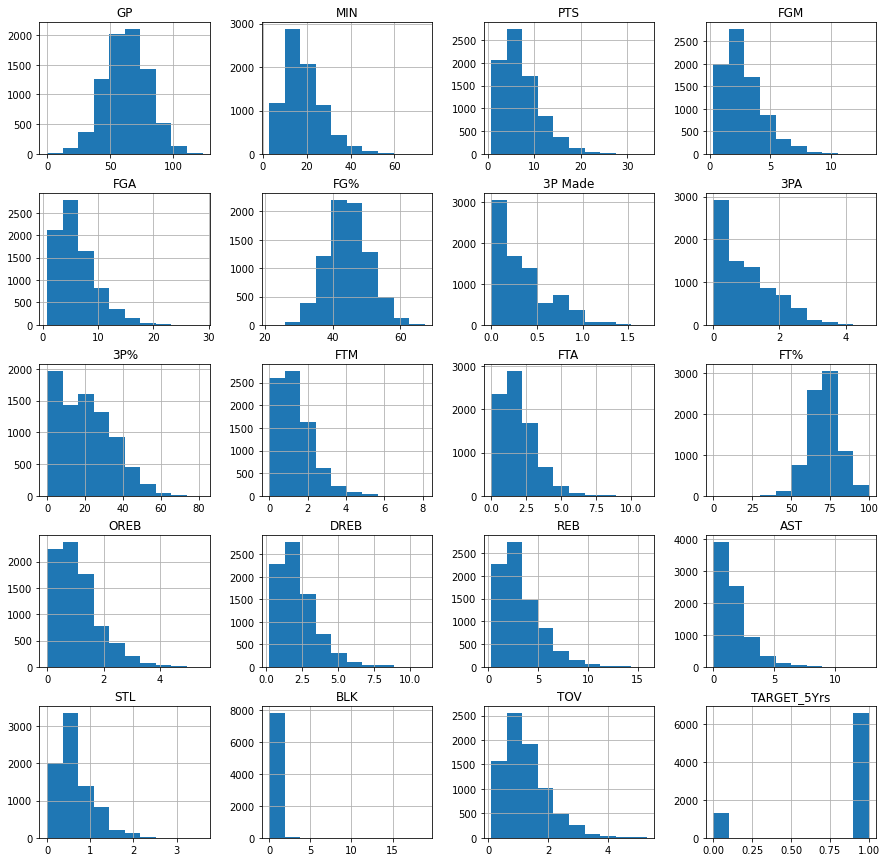

In [8]:
df_train.hist(figsize=[15,15])
plt.show()

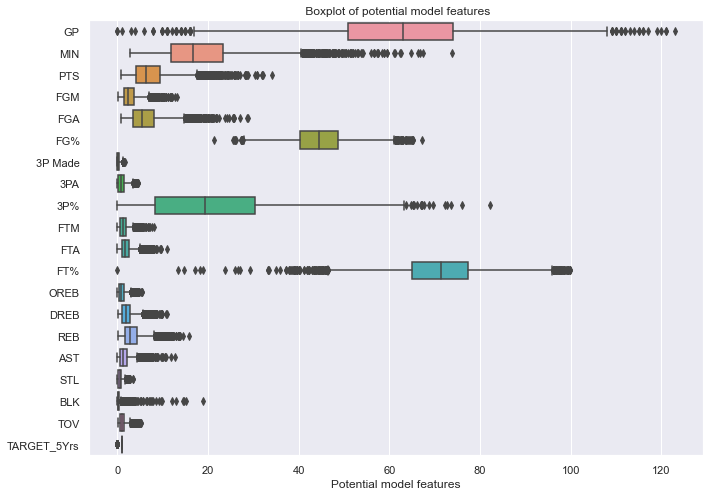

In [9]:
sns.set(rc={'figure.figsize':(11,8)})
sns.boxplot(data = df_train, orient = 'h')
plt.xlabel('Potential model features')
plt.title(' Boxplot of potential model features')
plt.savefig('/Users/james/projects/adsi/group1_nba_career_prediction/reports/figures/box_plot.png')

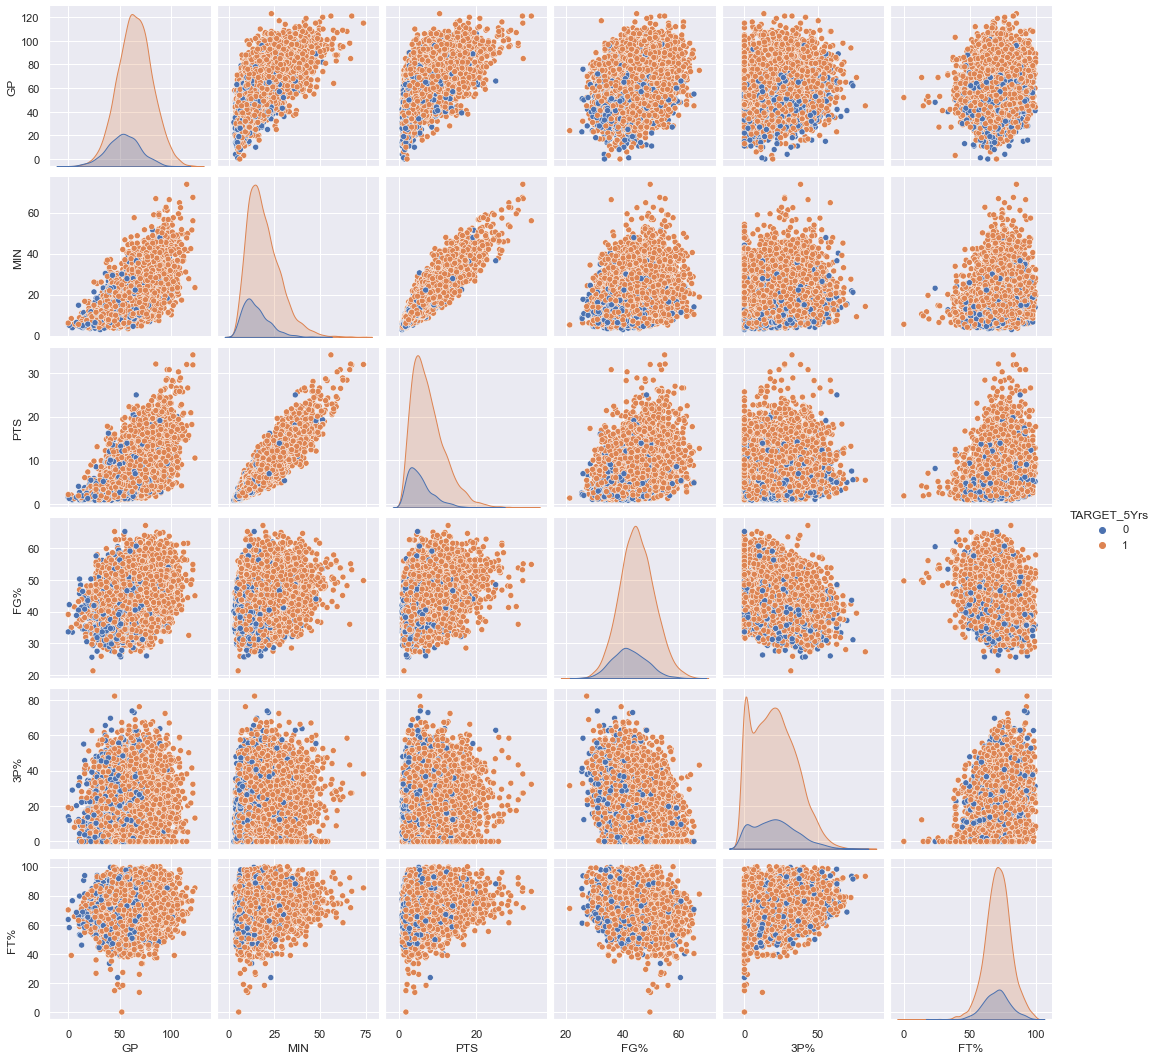

In [10]:
selected_features = df_train[["GP", "MIN", "PTS", "FG%", "TARGET_5Yrs", "3P%", "FT%"]]
selected_features
sns.pairplot(selected_features, hue = "TARGET_5Yrs")
plt.savefig('/Users/james/projects/adsi/group1_nba_career_prediction/reports/figures/pair_plot.png')

<AxesSubplot:>

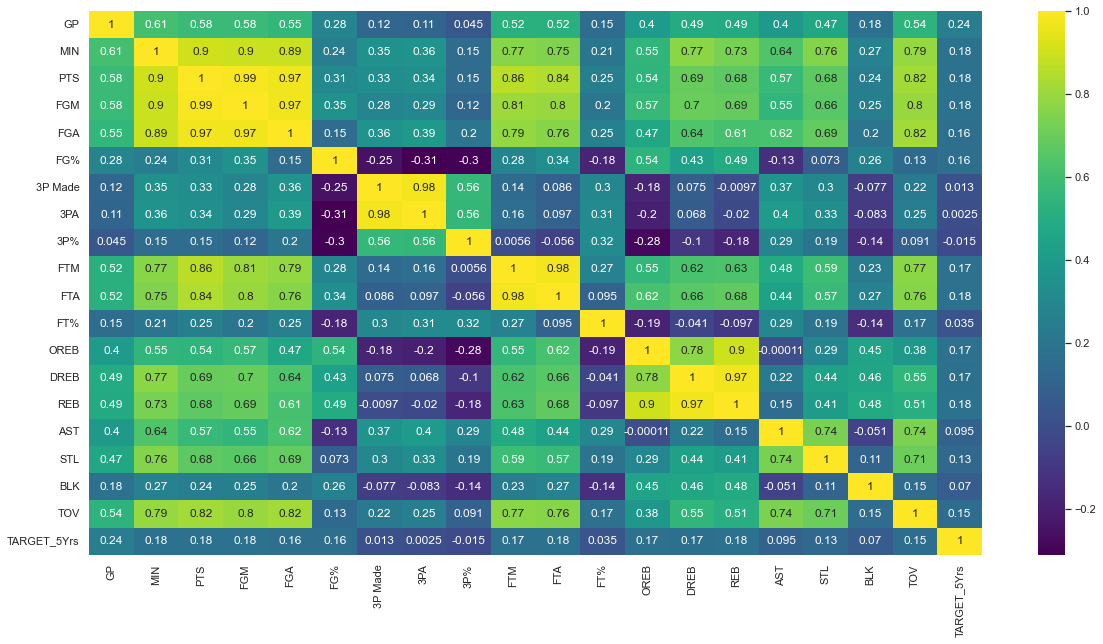

In [11]:
## Check for correlation between values to inform parameter selection for modelling
plt.figure(figsize=(20,10))
sns.heatmap(df_train.corr(),cmap='viridis',annot=True)

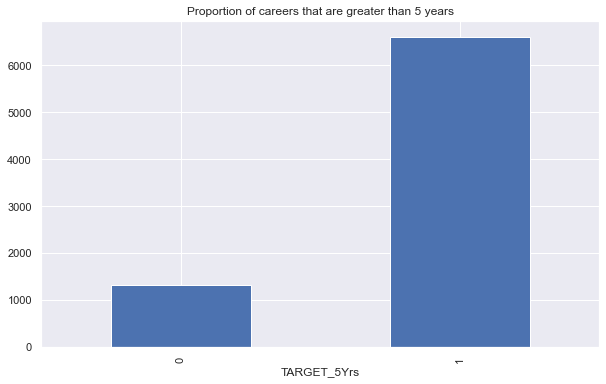

In [12]:
GroupedData=df_train.groupby('TARGET_5Yrs').size()
GroupedData.plot(kind='bar', figsize=(10,6))
plt.title('Proportion of careers that are greater than 5 years')
plt.savefig('/Users/james/projects/adsi/group1_nba_career_prediction/reports/figures/balanced_data.png')

There appears to be an imbalanced data set between the classes in the target variable. In order to reduce the effects of the model a weight will have to be applied to this to balance out the differences. Oversampling will be performed using SMOTE. 

In [13]:
df_train.columns

Index(['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM',
       'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'TARGET_5Yrs'],
      dtype='object')

## Build an initial model

In [14]:
## Separate the target variable from the rest of the variables
TargetVariable = df_train['TARGET_5Yrs']
print(TargetVariable)
Predictors = df_train.loc[:, ['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%','3P%','FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST']]
print(Predictors)
X = Predictors.values
y = TargetVariable.values
print(X)
print(y)

Id
10556    1
5342     1
5716     1
13790    1
5470     1
        ..
2996     1
11679    1
5537     1
1292     1
2900     1
Name: TARGET_5Yrs, Length: 7942, dtype: int64
       GP   MIN   PTS  FGM  FGA   FG%   3P%  FTM  FTA   FT%  OREB  DREB  REB  \
Id                                                                             
10556  80  24.3   7.8  3.0  6.4  45.7  22.6  2.0  2.9  72.1   2.2   2.0  3.8   
5342   75  21.8  10.5  4.2  7.9  55.1  34.9  2.4  3.6  67.8   3.6   3.7  6.6   
5716   85  19.1   4.5  1.9  4.5  42.8  34.3  0.4  0.6  75.7   0.6   1.8  2.4   
13790  63  19.1   8.2  3.5  6.7  52.5  23.7  0.9  1.5  66.9   0.8   2.0  3.0   
5470   63  17.8   3.7  1.7  3.4  50.8  13.7  0.2  0.5  54.0   2.4   2.7  4.9   
...    ..   ...   ...  ...  ...   ...   ...  ...  ...   ...   ...   ...  ...   
2996   32   9.2   1.8  0.7  1.8  40.3  23.1  0.4  0.6  65.7   0.3   1.8  1.9   
11679  54   6.0   1.8  0.7  1.4  48.7   3.1  0.2  0.4  70.1   1.0   1.1  2.0   
5537   85  28.2  10.7  4.0  9.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
## Impletement a SMOTE 
print('Before oversamplining:', Counter(y_train))

Before oversamplining: Counter({1: 4967, 0: 989})


In [17]:
# define oversampling strategy
SMOTE = SMOTE()
SMOTE

SMOTE()

In [18]:
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

In [19]:
print("After oversampling: ",Counter(y_train_SMOTE))

After oversampling:  Counter({1: 4967, 0: 4967})


In [20]:
## Build the model
from xgboost import XGBClassifier

clf=XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=1000, objective='binary:logistic', booster='gbtree')
print(clf)

XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)


In [48]:
## Create a model on the train data
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]


%time XGB=clf.fit(X_train_SMOTE, y_train_SMOTE, eval_set = eval_set, eval_metric = eval_metric, verbose = True)
XGB

## prediction on test data
prediction = XGB.predict(X_test)
prediction

[0]	validation_0-auc:0.72831	validation_0-error:0.30222	validation_1-auc:0.61492	validation_1-error:0.33787
[1]	validation_0-auc:0.73824	validation_0-error:0.27267	validation_1-auc:0.63034	validation_1-error:0.32326
[2]	validation_0-auc:0.74443	validation_0-error:0.27250	validation_1-auc:0.64427	validation_1-error:0.32024
[3]	validation_0-auc:0.75422	validation_0-error:0.27921	validation_1-auc:0.64388	validation_1-error:0.32880
[4]	validation_0-auc:0.75753	validation_0-error:0.27149	validation_1-auc:0.64944	validation_1-error:0.31823
[5]	validation_0-auc:0.75795	validation_0-error:0.27837	validation_1-auc:0.65810	validation_1-error:0.31772
[6]	validation_0-auc:0.76294	validation_0-error:0.26897	validation_1-auc:0.66105	validation_1-error:0.31672
[7]	validation_0-auc:0.76376	validation_0-error:0.27283	validation_1-auc:0.65972	validation_1-error:0.32326
[8]	validation_0-auc:0.76572	validation_0-error:0.27132	validation_1-auc:0.66331	validation_1-error:0.31621
[9]	validation_0-auc:0.76591

[76]	validation_0-auc:0.89424	validation_0-error:0.12240	validation_1-auc:0.66480	validation_1-error:0.19839
[77]	validation_0-auc:0.89563	validation_0-error:0.12189	validation_1-auc:0.66544	validation_1-error:0.19789
[78]	validation_0-auc:0.89656	validation_0-error:0.12122	validation_1-auc:0.66382	validation_1-error:0.19688
[79]	validation_0-auc:0.89722	validation_0-error:0.12139	validation_1-auc:0.66358	validation_1-error:0.19587
[80]	validation_0-auc:0.89896	validation_0-error:0.12072	validation_1-auc:0.66292	validation_1-error:0.19789
[81]	validation_0-auc:0.90070	validation_0-error:0.12206	validation_1-auc:0.66222	validation_1-error:0.19486
[82]	validation_0-auc:0.90071	validation_0-error:0.12173	validation_1-auc:0.66340	validation_1-error:0.19486
[83]	validation_0-auc:0.90268	validation_0-error:0.12089	validation_1-auc:0.66368	validation_1-error:0.19335
[84]	validation_0-auc:0.90431	validation_0-error:0.11937	validation_1-auc:0.66239	validation_1-error:0.19486
[85]	validation_0-a

[151]	validation_0-auc:0.96506	validation_0-error:0.08781	validation_1-auc:0.64365	validation_1-error:0.18983
[152]	validation_0-auc:0.96560	validation_0-error:0.08764	validation_1-auc:0.64302	validation_1-error:0.18983
[153]	validation_0-auc:0.96566	validation_0-error:0.08731	validation_1-auc:0.64303	validation_1-error:0.18983
[154]	validation_0-auc:0.96634	validation_0-error:0.08731	validation_1-auc:0.64310	validation_1-error:0.19033
[155]	validation_0-auc:0.96701	validation_0-error:0.08680	validation_1-auc:0.64377	validation_1-error:0.18882
[156]	validation_0-auc:0.96808	validation_0-error:0.08563	validation_1-auc:0.64432	validation_1-error:0.18983
[157]	validation_0-auc:0.96894	validation_0-error:0.08546	validation_1-auc:0.64378	validation_1-error:0.18932
[158]	validation_0-auc:0.96948	validation_0-error:0.08479	validation_1-auc:0.64398	validation_1-error:0.19084
[159]	validation_0-auc:0.97007	validation_0-error:0.08428	validation_1-auc:0.64426	validation_1-error:0.19235
[160]	vali

[226]	validation_0-auc:0.98839	validation_0-error:0.06330	validation_1-auc:0.63197	validation_1-error:0.19084
[227]	validation_0-auc:0.98858	validation_0-error:0.06279	validation_1-auc:0.63247	validation_1-error:0.19084
[228]	validation_0-auc:0.98862	validation_0-error:0.06246	validation_1-auc:0.63260	validation_1-error:0.19084
[229]	validation_0-auc:0.98878	validation_0-error:0.06212	validation_1-auc:0.63289	validation_1-error:0.19084
[230]	validation_0-auc:0.98911	validation_0-error:0.06028	validation_1-auc:0.63321	validation_1-error:0.19285
[231]	validation_0-auc:0.98914	validation_0-error:0.05994	validation_1-auc:0.63330	validation_1-error:0.19235
[232]	validation_0-auc:0.98927	validation_0-error:0.05960	validation_1-auc:0.63323	validation_1-error:0.19184
[233]	validation_0-auc:0.98951	validation_0-error:0.05927	validation_1-auc:0.63298	validation_1-error:0.19235
[234]	validation_0-auc:0.98959	validation_0-error:0.05910	validation_1-auc:0.63261	validation_1-error:0.19285
[235]	vali

[301]	validation_0-auc:0.99700	validation_0-error:0.03929	validation_1-auc:0.62605	validation_1-error:0.19134
[302]	validation_0-auc:0.99713	validation_0-error:0.03811	validation_1-auc:0.62595	validation_1-error:0.19033
[303]	validation_0-auc:0.99721	validation_0-error:0.03811	validation_1-auc:0.62612	validation_1-error:0.19184
[304]	validation_0-auc:0.99735	validation_0-error:0.03710	validation_1-auc:0.62638	validation_1-error:0.19235
[305]	validation_0-auc:0.99741	validation_0-error:0.03694	validation_1-auc:0.62600	validation_1-error:0.19285
[306]	validation_0-auc:0.99744	validation_0-error:0.03610	validation_1-auc:0.62631	validation_1-error:0.19285
[307]	validation_0-auc:0.99744	validation_0-error:0.03610	validation_1-auc:0.62642	validation_1-error:0.19285
[308]	validation_0-auc:0.99747	validation_0-error:0.03559	validation_1-auc:0.62615	validation_1-error:0.19235
[309]	validation_0-auc:0.99747	validation_0-error:0.03559	validation_1-auc:0.62630	validation_1-error:0.19235
[310]	vali

[376]	validation_0-auc:0.99923	validation_0-error:0.02384	validation_1-auc:0.62348	validation_1-error:0.19335
[377]	validation_0-auc:0.99923	validation_0-error:0.02351	validation_1-auc:0.62353	validation_1-error:0.19285
[378]	validation_0-auc:0.99923	validation_0-error:0.02334	validation_1-auc:0.62380	validation_1-error:0.19285
[379]	validation_0-auc:0.99924	validation_0-error:0.02317	validation_1-auc:0.62377	validation_1-error:0.19235
[380]	validation_0-auc:0.99924	validation_0-error:0.02317	validation_1-auc:0.62376	validation_1-error:0.19386
[381]	validation_0-auc:0.99926	validation_0-error:0.02283	validation_1-auc:0.62329	validation_1-error:0.19486
[382]	validation_0-auc:0.99927	validation_0-error:0.02283	validation_1-auc:0.62349	validation_1-error:0.19486
[383]	validation_0-auc:0.99926	validation_0-error:0.02283	validation_1-auc:0.62331	validation_1-error:0.19436
[384]	validation_0-auc:0.99927	validation_0-error:0.02283	validation_1-auc:0.62349	validation_1-error:0.19537
[385]	vali

[451]	validation_0-auc:0.99978	validation_0-error:0.01427	validation_1-auc:0.62000	validation_1-error:0.19235
[452]	validation_0-auc:0.99979	validation_0-error:0.01394	validation_1-auc:0.61967	validation_1-error:0.19184
[453]	validation_0-auc:0.99980	validation_0-error:0.01360	validation_1-auc:0.62013	validation_1-error:0.19235
[454]	validation_0-auc:0.99983	validation_0-error:0.01343	validation_1-auc:0.61937	validation_1-error:0.19235
[455]	validation_0-auc:0.99983	validation_0-error:0.01343	validation_1-auc:0.61908	validation_1-error:0.19184
[456]	validation_0-auc:0.99983	validation_0-error:0.01343	validation_1-auc:0.61912	validation_1-error:0.19184
[457]	validation_0-auc:0.99983	validation_0-error:0.01310	validation_1-auc:0.61898	validation_1-error:0.19184
[458]	validation_0-auc:0.99983	validation_0-error:0.01310	validation_1-auc:0.61888	validation_1-error:0.19134
[459]	validation_0-auc:0.99983	validation_0-error:0.01310	validation_1-auc:0.61889	validation_1-error:0.19134
[460]	vali

[526]	validation_0-auc:0.99997	validation_0-error:0.00705	validation_1-auc:0.61742	validation_1-error:0.19285
[527]	validation_0-auc:0.99997	validation_0-error:0.00705	validation_1-auc:0.61732	validation_1-error:0.19235
[528]	validation_0-auc:0.99997	validation_0-error:0.00688	validation_1-auc:0.61740	validation_1-error:0.19335
[529]	validation_0-auc:0.99997	validation_0-error:0.00688	validation_1-auc:0.61745	validation_1-error:0.19335
[530]	validation_0-auc:0.99997	validation_0-error:0.00688	validation_1-auc:0.61721	validation_1-error:0.19335
[531]	validation_0-auc:0.99997	validation_0-error:0.00688	validation_1-auc:0.61713	validation_1-error:0.19285
[532]	validation_0-auc:0.99997	validation_0-error:0.00688	validation_1-auc:0.61696	validation_1-error:0.19335
[533]	validation_0-auc:0.99997	validation_0-error:0.00638	validation_1-auc:0.61695	validation_1-error:0.19386
[534]	validation_0-auc:0.99997	validation_0-error:0.00638	validation_1-auc:0.61684	validation_1-error:0.19335
[535]	vali

[601]	validation_0-auc:1.00000	validation_0-error:0.00420	validation_1-auc:0.61617	validation_1-error:0.19386
[602]	validation_0-auc:1.00000	validation_0-error:0.00386	validation_1-auc:0.61632	validation_1-error:0.19335
[603]	validation_0-auc:1.00000	validation_0-error:0.00386	validation_1-auc:0.61632	validation_1-error:0.19386
[604]	validation_0-auc:1.00000	validation_0-error:0.00386	validation_1-auc:0.61657	validation_1-error:0.19386
[605]	validation_0-auc:1.00000	validation_0-error:0.00386	validation_1-auc:0.61643	validation_1-error:0.19436
[606]	validation_0-auc:1.00000	validation_0-error:0.00369	validation_1-auc:0.61694	validation_1-error:0.19436
[607]	validation_0-auc:1.00000	validation_0-error:0.00369	validation_1-auc:0.61690	validation_1-error:0.19486
[608]	validation_0-auc:1.00000	validation_0-error:0.00369	validation_1-auc:0.61684	validation_1-error:0.19436
[609]	validation_0-auc:1.00000	validation_0-error:0.00369	validation_1-auc:0.61689	validation_1-error:0.19486
[610]	vali

[676]	validation_0-auc:1.00000	validation_0-error:0.00084	validation_1-auc:0.61352	validation_1-error:0.19285
[677]	validation_0-auc:1.00000	validation_0-error:0.00084	validation_1-auc:0.61352	validation_1-error:0.19184
[678]	validation_0-auc:1.00000	validation_0-error:0.00084	validation_1-auc:0.61350	validation_1-error:0.19134
[679]	validation_0-auc:1.00000	validation_0-error:0.00101	validation_1-auc:0.61354	validation_1-error:0.19184
[680]	validation_0-auc:1.00000	validation_0-error:0.00084	validation_1-auc:0.61312	validation_1-error:0.19184
[681]	validation_0-auc:1.00000	validation_0-error:0.00084	validation_1-auc:0.61328	validation_1-error:0.19184
[682]	validation_0-auc:1.00000	validation_0-error:0.00084	validation_1-auc:0.61285	validation_1-error:0.19285
[683]	validation_0-auc:1.00000	validation_0-error:0.00084	validation_1-auc:0.61291	validation_1-error:0.19285
[684]	validation_0-auc:1.00000	validation_0-error:0.00084	validation_1-auc:0.61297	validation_1-error:0.19285
[685]	vali

[751]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60986	validation_1-error:0.19184
[752]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60986	validation_1-error:0.19335
[753]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.61001	validation_1-error:0.19335
[754]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.61016	validation_1-error:0.19335
[755]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.61016	validation_1-error:0.19285
[756]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.61023	validation_1-error:0.19285
[757]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.61022	validation_1-error:0.19335
[758]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.61016	validation_1-error:0.19335
[759]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.61029	validation_1-error:0.19335
[760]	vali

[826]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60923	validation_1-error:0.19235
[827]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60939	validation_1-error:0.19235
[828]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60927	validation_1-error:0.19285
[829]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60941	validation_1-error:0.19235
[830]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60956	validation_1-error:0.19084
[831]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60944	validation_1-error:0.19134
[832]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60978	validation_1-error:0.19184
[833]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60980	validation_1-error:0.19184
[834]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60963	validation_1-error:0.19184
[835]	vali

[901]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60978	validation_1-error:0.19486
[902]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.61000	validation_1-error:0.19537
[903]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.61005	validation_1-error:0.19537
[904]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.61007	validation_1-error:0.19486
[905]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.61013	validation_1-error:0.19537
[906]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.61035	validation_1-error:0.19537
[907]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.61055	validation_1-error:0.19537
[908]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.61073	validation_1-error:0.19738
[909]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.61075	validation_1-error:0.19688
[910]	vali

[976]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60981	validation_1-error:0.19537
[977]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60982	validation_1-error:0.19537
[978]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60986	validation_1-error:0.19537
[979]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60986	validation_1-error:0.19537
[980]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60996	validation_1-error:0.19537
[981]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60970	validation_1-error:0.19486
[982]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60982	validation_1-error:0.19486
[983]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60954	validation_1-error:0.19486
[984]	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-auc:0.60962	validation_1-error:0.19537
[985]	vali

array([1, 1, 1, ..., 1, 1, 1])

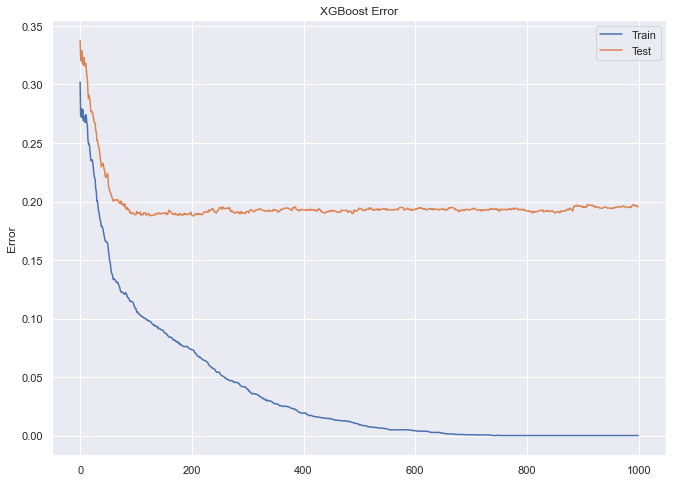

In [50]:
results = XGB.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.savefig('/Users/james/projects/adsi/group1_nba_career_prediction/reports/figures/train_test_error.png')

In [22]:
XGB

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
## Measure accuracy of prediction
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.30      0.11      0.16       338
           1       0.84      0.95      0.89      1648

    accuracy                           0.80      1986
   macro avg       0.57      0.53      0.53      1986
weighted avg       0.75      0.80      0.77      1986



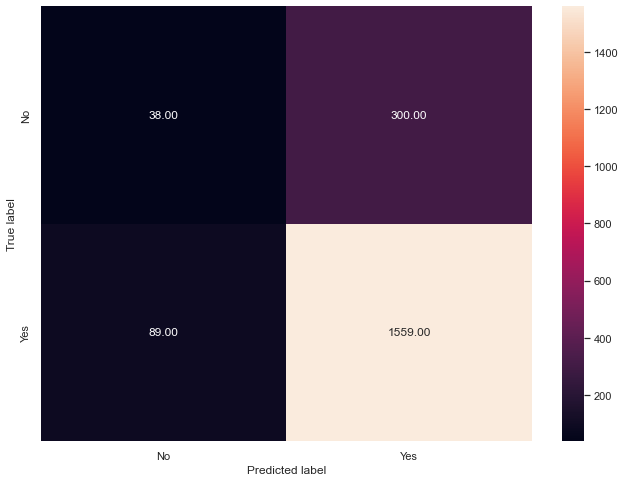

In [38]:
cm = metrics.confusion_matrix(y_test, prediction)

sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["No", "Yes"] , yticklabels = ["No", "Yes"],)
plt.ylabel('True label',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)
plt.savefig('/Users/james/projects/adsi/group1_nba_career_prediction/reports/figures/confusion_matrix.png')

In [26]:
Predictors.reset_index(drop=True)

,GP,MIN,PTS,FGM,FGA,FG%,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST
0,80,24.3,7.8,3.0,6.4,45.7,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2
1,75,21.8,10.5,4.2,7.9,55.1,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7
2,85,19.1,4.5,1.9,4.5,42.8,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8
3,63,19.1,8.2,3.5,6.7,52.5,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8
4,63,17.8,3.7,1.7,3.4,50.8,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7937,32,9.2,1.8,0.7,1.8,40.3,23.1,0.4,0.6,65.7,0.3,1.8,1.9,0.5
7938,54,6.0,1.8,0.7,1.4,48.7,3.1,0.2,0.4,70.1,1.0,1.1,2.0,0.1
7939,85,28.2,10.7,4.0,9.0,45.1,23.6,2.8,3.9,69.7,1.0,2.1,3.1,3.4
7940,39,7.7,2.5,1.0,2.3,40.1,13.3,0.6,0.7,74.3,0.4,0.6,0.9,0.2


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

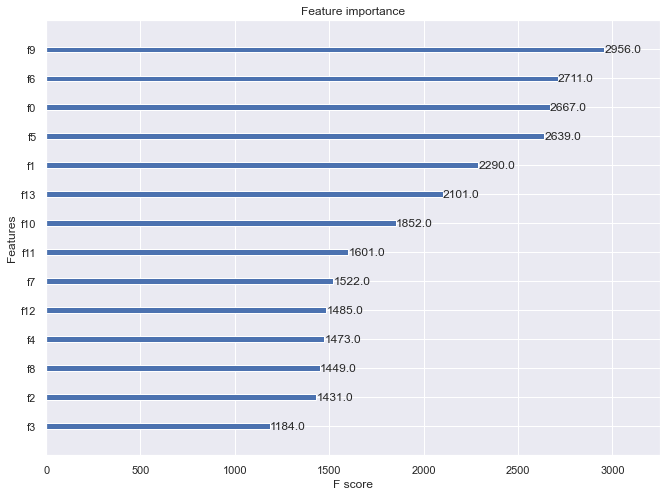

In [27]:
plot_importance(XGB)

<BarContainer object of 14 artists>

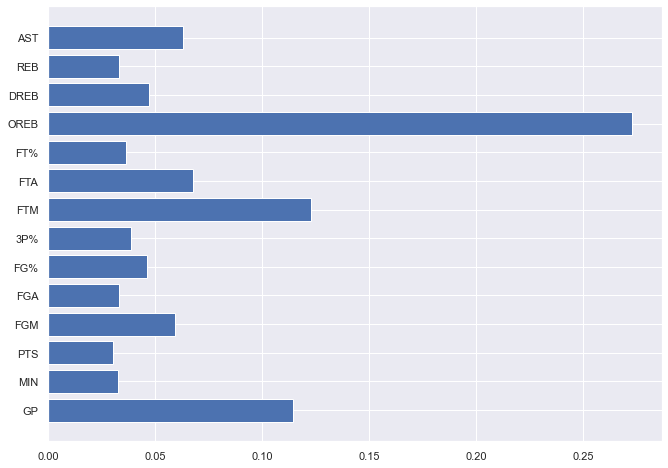

In [28]:
## Plot feature importance 
XGB.feature_importances_
plt.barh(Predictors.reset_index(drop=True).columns, XGB.feature_importances_)

In [29]:
X_test
Predictors = Predictors.reset_index(drop=True)
Predictors.columns

Index(['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P%', 'FTM', 'FTA', 'FT%',
       'OREB', 'DREB', 'REB', 'AST'],
      dtype='object')

In [30]:
results = pd.DataFrame(data = X_test, columns = Predictors.columns)
results['Target'] = y_test
results['Prediction'] = prediction
results['Target'].unique()

array([1, 0])

In [31]:
## Load and pre-process test data
df_test

,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,1,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,7.3,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,8194,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,35.1,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,-0.0,1.8
2,3,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,44.8,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,8196,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,13.5,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,8197,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,38.7,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3794,8175,84,21.2,8.7,3.4,6.7,50.2,0.0,-0.0,-4.5,1.7,2.5,68.1,1.9,2.3,3.9,1.5,0.6,0.3,2.0
3795,8176,49,16.3,6.4,2.9,6.6,44.4,-0.1,-0.4,19.8,1.0,1.9,50.2,1.7,2.8,4.4,0.4,0.4,0.4,0.7
3796,8178,53,9.9,2.1,0.8,1.8,43.1,-0.4,-0.6,1.9,0.6,1.0,63.9,0.7,1.0,1.7,0.4,0.4,0.2,0.5
3797,8181,89,38.3,14.5,5.4,11.8,45.2,0.5,1.2,24.7,2.5,2.9,89.2,1.5,4.0,5.5,3.7,1.3,0.3,2.4


In [32]:
# Remove negative values to clean the data
df_test[df_test < 0] = 0


In [33]:
## Remove outlier percentages - i.e those that are greater than 100%
#print(df_test[df_test['FT%'] > 100])
#df_test = df_test[df_test['FT%'] < 100]
#df_test.describe()

In [34]:
## Load test data 
pred_cols = Predictors.columns
pred_cols
df_test_pred = df_test[pred_cols]
df_test_pred

,GP,MIN,PTS,FGM,FGA,FG%,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST
0,56,9.1,4.0,1.6,3.7,43.7,7.3,0.7,1.2,63.4,1.2,0.8,1.7,0.4
1,43,19.3,10.1,3.7,8.1,46.0,35.1,1.8,2.5,75.3,0.5,0.9,1.5,3.5
2,82,33.9,11.3,4.9,10.6,45.6,44.8,1.8,2.7,71.2,1.3,3.3,4.5,2.5
3,86,44.7,18.8,6.8,15.9,42.9,13.5,4.5,6.3,70.9,1.5,3.2,5.0,4.1
4,58,12.3,4.7,1.6,4.0,40.0,38.7,1.1,1.3,76.9,0.2,0.6,0.9,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3794,84,21.2,8.7,3.4,6.7,50.2,0.0,1.7,2.5,68.1,1.9,2.3,3.9,1.5
3795,49,16.3,6.4,2.9,6.6,44.4,19.8,1.0,1.9,50.2,1.7,2.8,4.4,0.4
3796,53,9.9,2.1,0.8,1.8,43.1,1.9,0.6,1.0,63.9,0.7,1.0,1.7,0.4
3797,89,38.3,14.5,5.4,11.8,45.2,24.7,2.5,2.9,89.2,1.5,4.0,5.5,3.7


In [35]:
test_pred = pd.DataFrame(XGB.predict_proba(df_test_pred))
test_pred_df = pd.DataFrame(test_pred[1])
test_pred_df.columns = ['TARGET_5Yrs']
test_pred_df

/Users/james/projects/adsi/adsi/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,TARGET_5Yrs
0,0.955188
1,0.804054
2,0.997897
3,0.989476
4,0.297571
...,...
3794,0.996530
3795,0.753845
3796,0.875412
3797,0.798075


In [36]:
Id = pd.DataFrame(df_test['Id'])
Id

,Id
0,1
1,8194
2,3
3,8196
4,8197
...,...
3794,8175
3795,8176
3796,8178
3797,8181


In [37]:
submission = Id.join(test_pred_df)
submission.to_csv('/Users/james/projects/adsi/group1_nba_career_prediction/models/model_1_1.csv', index = False)